In [1]:
from openff.toolkit import ForceField, Molecule
from openmm import openmm
from openmm import unit
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw
import numpy as np

In [2]:
class Reporter(openmm.MinimizationReporter):
    interval = 10 # report interval
    energies = [] # array to record progress
    def report(self, iteration, x, grad, args):
        # print current system energy to screen 
        if iteration % self.interval == 0:
            print(iteration, args['system energy'])

        # save energy at each iteration to an array we can use later
        self.energies.append(args['system energy'])

        # The report method must return a bool specifying if minimization should be stopped. 
        return False

In [3]:
mol = Molecule.from_smiles('CCCC(O)CC(N)CCC', allow_undefined_stereo=True)
mol.generate_conformers()
# mol.assign_partial_charges(partial_charge_method='am1bccelf10')

In [4]:
print(f"Number of atoms in molecule: {mol.n_atoms}")
print(f"Number of conformers: {len(mol.conformers)}")


Number of atoms in molecule: 32
Number of conformers: 1


In [5]:
forcefield = ForceField('lee-krimm-force-field.offxml', load_plugins = True, allow_cosmetic_attributes = True)
# forcefield = ForceField('openff-2.2.0.offxml')

In [6]:
system = forcefield.create_openmm_system(mol.to_topology())


In [7]:
for i in range(system.getNumForces()):
    force = system.getForce(i)
    print(f"Force {i}: {type(force)}")


Force 0: <class 'openmm.openmm.NonbondedForce'>
Force 1: <class 'openmm.openmm.PeriodicTorsionForce'>
Force 2: <class 'openmm.openmm.HarmonicAngleForce'>
Force 3: <class 'openmm.openmm.HarmonicBondForce'>
Force 4: <class 'openmm.openmm.CustomCompoundBondForce'>


In [8]:
print(system.getNumParticles()) 

32


In [9]:
integrator = openmm.LangevinIntegrator(
    300.0 * unit.kelvin, 1.0 / unit.picosecond, 2.0 * unit.femtosecond
)
platform = openmm.Platform.getPlatformByName("Reference")
context = openmm.Context(system, integrator, platform)

initial_positions = mol.conformers[0].to_openmm()
context.setPositions(initial_positions)

# Create an instance of our reporter
reporter = Reporter()

# Perform local energy minimization
print("Minimizing energy...")
openmm.LocalEnergyMinimizer.minimize(
    context, tolerance=1e-2, maxIterations=1500, reporter=reporter
)

Minimizing energy...
0 78.70394052617142
10 11.648875113998898
20 -9.685525996665822
30 -16.79874995096272
40 -19.910333605156094
50 -21.14524897404649
60 -21.910488810928417
70 -22.30443108463016
80 -22.480306725407484
90 -22.54210443598984
100 -22.58233004041466
110 -22.598656131010497
120 -22.61213766819119
130 -22.623435452066072
140 -22.63090811735999
150 -22.635765602755317
160 -22.639143991915297
170 -22.639648072152998
180 -22.640107234451705
190 -22.640370501009574
200 -22.64061182563775
210 -22.640781329420882
220 -22.640873461931765
230 -22.640984133393978
240 -22.641051905280356
250 -22.641103922810732
260 -22.641128954556606
270 -22.641146093189096
280 -22.641154071431956
290 -22.641156556873753
300 -22.641158260253924
310 -22.64115970084173
320 -22.6411611546341
330 -22.641161510714575
340 -22.64116172905208
350 -22.64116196556925
360 -22.64116208772617
370 -22.641162132487214


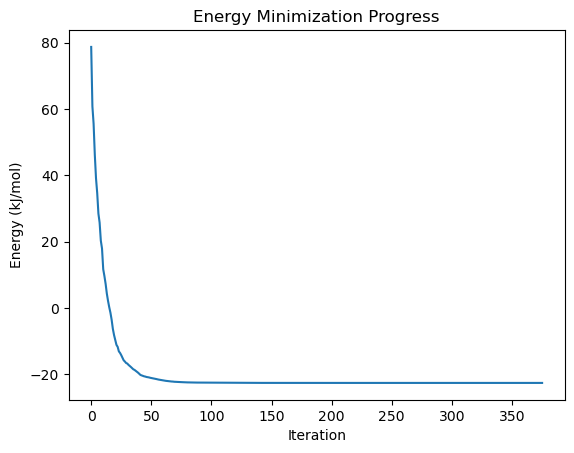

In [10]:
plt.plot(reporter.energies)
plt.xlabel("Iteration")
plt.ylabel("Energy (kJ/mol)")
plt.title("Energy Minimization Progress")
plt.show()

In [11]:
xml_file_name = "lee_krimm_benchmark_system.xml"
with open(xml_file_name, "w") as xml_file:
    xml_file.write(openmm.XmlSerializer.serialize(system))